# Initial attempt

In [ ]:
import requests
import pandas as pd
import datetime as dt


api_key = "26f63d53-90e3-459c-b7ba-1acb658f2f55"

DMI_URL = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'
r = requests.get(DMI_URL, params={'api-key': api_key}) # Issues a HTTP GET request
json = r.json()  # Extract JSON data
df = pd.json_normalize(json['features'])  # Convert JSON object to a Pandas DataFrame
df.head()  # Print the first five rows of the DataFrame
df['time'] = pd.to_datetime(df['properties.observed'])


In [ ]:
parameterIds = df['properties.parameterId'].unique()  # Generate a list of unique parameter ids
print(parameterIds)  # Print all unique parameter ids

In [ ]:
# Specify the desired start and end time
startTime = pd.Timestamp(2022, 1, 1)
endTime = pd.Timestamp(2022, 1, 15)

# Specify one or more station IDs or all_stations
stationIds = [
    '04203', '04208', '04214', '04220', '04228', '04242', '04250',
    '04253', '04266', '04271', '04272', '04285', '04301', '04312',
    '04313', '04320', '04330', '04339', '04351', '04360', '04373',
    '04382', '04390', '05005', '05009', '05015', '05031', '05035',
    '05042', '05065', '05070', '05075', '05081', '05085', '05089',
    '05095', '05105', '05109', '05135', '05140', '05150', '05160',
    '05165', '05169', '05185', '05199', '05202', '05205', '05220',
    '05225', '05269', '05272', '05276', '05277', '05290', '05296',
    '05300', '05305', '05320', '05329', '05343', '05345', '05350',
    '05355', '05365', '05375', '05381', '05395', '05400', '05406',
    '05408', '05435', '05440', '05450', '05455', '05469', '05499',
    '05505', '05510', '05529', '05537', '05545', '05575', '05735',
    '05880', '05889', '05935', '05945', '05970', '05986', '05994',
    '06019', '06031', '06032', '06041', '06049', '06051', '06052',
    '06056', '06058', '06065', '06068', '06072', '06073', '06074',
    '06079', '06081', '06082', '06088', '06093', '06096', '06102',
    '06116', '06119', '06123', '06124', '06126', '06132', '06135',
    '06136', '06138', '06141', '06147', '06149', '06151', '06154',
    '06156', '06159', '06168', '06169', '06174', '06181', '06183',
    '06184', '06186', '06187', '06188', '06193', '06197', '20000',
    '20030', '20055', '20085', '20228', '20279', '20315', '20375',
    '20400', '20552', '20561', '20600', '20670', '21020', '21080',
    '21100', '21120', '21160', '21208', '21368', '21430', '22020',
    '22080', '22162', '22189', '22232', '22410', '23100', '23133',
    '23160', '23327', '23360', '24043', '24102', '24142', '24171',
    '24380', '24430', '24490', '25045', '25161', '25270', '25339',
    '26210', '26340', '26358', '26450', '27008', '27082', '28032',
    '28110', '28240', '28280', '28385', '28552', '28590', '29020',
    '29194', '29243', '29330', '29440', '30075', '30187', '30215',
    '30414', '31040', '31185', '31199', '31259', '31350', '31400',
    '31509', '31570', '32110', '32175', '34270', '34320', '34339'
]
# Specify one or more parameter IDs or all_parameters
parameterIds = [
    # Humdity
    'humidity', 'humidity_past1h',
    # Precipitation
    'precip_past10min', 'precip_past1h', 'precip_past24h',   
    # Temperature
    'temp_dew', 'temp_dry', 'temp_max_past12h', 'temp_max_past1h',
    'temp_mean_past1h', 'temp_min_past12h', 'temp_min_past1h',
]

# Derive datetime specifier string
datetime_str = startTime.tz_localize('UTC').isoformat() + '/' + endTime.tz_localize('UTC').isoformat()

dfs = []
for station in stationIds:
    for parameter in parameterIds:
        # Specify query parameters
        params = {
            'api-key' : api_key,
            'datetime' : datetime_str,
            'stationIds' : station,
            'parameterId' : parameter,
            'limit' : '300000',  # max limit
        }

        # Submit GET request with url and parameters
        r = requests.get(DMI_URL, params=params)
        # Extract JSON object
        json = r.json() # Extract JSON object
        # Convert JSON object to a MultiIndex DataFrame and add to list
        dfi = pd.json_normalize(json['features'])
        if dfi.empty is False:
            dfi['time'] = pd.to_datetime(dfi['properties.observed'])
            # Drop other columns
            dfi = dfi[['time', 'properties.value', 'properties.stationIds', 'properties.parameterId']]
            # Rename columns, e.g., 'properties.stationIds' becomes 'stationIds'
            dfi.columns = [c.replace('properties.', '') for c in dfi.columns]
            # Drop identical rows (considers both value and time stamp)
            dfi = dfi[~dfi.duplicated()]
            dfi = dfi.set_index(['parameterId', 'stationIds', 'time'])
            dfi = dfi['value'].unstack(['stationIds','parameterId'])
            dfs.append(dfi)

    # create a log for each station id
    print(f"Station {station}/{len(stationIds)} has been processed")        

df = pd.concat(dfs, axis='columns').sort_index()
df.head()



In [ ]:
import requests
import json
import pandas as pd
import datetime
import concurrent.futures
from typing import Dict, List, Optional, Union, Tuple

# Base URL for DMI Meteorological Observation API
BASE_URL = "https://dmigw.govcloud.dk/v2/metObs/collections/observation/items"

def fetch_single_request(api_key: str, 
                        stationId: str, 
                        parameterIds: str, 
                        datetime_str: str,
                        limit: int = 300000) -> Tuple[str, str, pd.DataFrame]:
    """
    Fetch data for a single station-parameter combination.
    
    Args:
        api_key: Your DMI API key
        stationId: Station ID
        parameterIds: Parameter ID
        datetime_str: Formatted datetime range string
        limit: Maximum number of records to return
        
    Returns:
        Tuple containing stationId, parameterIds, and resulting DataFrame
    """
    headers = {"X-API-Key": api_key}
    
    params = {
        'datetime': datetime_str,
        'stationIds': stationId,
        'parameterId': parameterIds,
        'limit': str(limit),
    }
    
    try:
        response = requests.get(BASE_URL, headers=headers, params=params)
        
        if response.status_code == 200:
            json_data = response.json()
            df = pd.json_normalize(json_data.get('features', []))
            
            if not df.empty:
                df['time'] = pd.to_datetime(df['properties.observed'])
                df = df[['time', 'properties.value', 'properties.stationIds', 'properties.parameterId']]
                df.columns = [c.replace('properties.', '') for c in df.columns]
                df = df[~df.duplicated()]
                
                return stationId, parameterIds, df
        
        print(f"No data or error for station {stationId}, parameter {parameterIds}")
        return stationId, parameterIds, pd.DataFrame()
        
    except Exception as e:
        print(f"Error for station {stationId}, parameter {parameterIds}: {str(e)}")
        return stationId, parameterIds, pd.DataFrame()

def get_all_data_concurrent(api_key: str,
                           stationIds: List[str],
                           parameterIds: List[str],
                           startTime: pd.Timestamp,
                           endTime: pd.Timestamp,
                           max_workers: int = 10,
                           limit: int = 300000) -> pd.DataFrame:
    """
    Fetch meteorological data for multiple stations and parameters concurrently.
    
    Args:
        api_key: Your DMI API key
        stationIds: List of station IDs
        parameterIds: List of parameter IDs
        startTime: Start timestamp
        endTime: End timestamp
        max_workers: Maximum number of concurrent requests
        limit: Maximum records per request
        
    Returns:
        DataFrame with meteorological data
    """
    # Convert timestamps to ISO format with UTC timezone
    datetime_str = startTime.tz_localize('UTC').isoformat() + '/' + endTime.tz_localize('UTC').isoformat()
    
    all_dfs = []
    total_tasks = len(stationIds) * len(parameterIds)
    completed = 0
    
    # Use ThreadPoolExecutor for concurrent requests
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Create a list of futures
        futures = []
        for station in stationIds:
            for parameter in parameterIds:
                futures.append(
                    executor.submit(
                        fetch_single_request, 
                        api_key, 
                        station, 
                        parameter, 
                        datetime_str, 
                        limit
                    )
                )
        
        # Process completed futures
        for future in concurrent.futures.as_completed(futures):
            completed += 1
            try:
                stationId, parameterId, df = future.result()
                if not df.empty:
                    print(f"Completed {completed}/{total_tasks}: Station {stationId}, Parameter {parameterIds}")
                    all_dfs.append(df)
                else:
                    print(f"No data for {completed}/{total_tasks}: Station {stationId}, Parameter {parameterIds}")
            except Exception as e:
                print(f"Error processing task {completed}/{total_tasks}: {str(e)}")
    
    # Combine all dataframes
    if all_dfs:
        # Concatenate all dataframes
        combined_df = pd.concat(all_dfs, ignore_index=True)
        
        # Set multi-index and pivot the DataFrame
        # First, convert value column to numeric to ensure proper aggregation
        combined_df['value'] = pd.to_numeric(combined_df['value'], errors='coerce')
        
        # Create the multi-index and unstack
        pivoted_df = combined_df.pivot_table(
            index='time', 
            columns=['parameterId', 'stationIds'], 
            values='value',
            aggfunc='mean'  # In case of duplicates
        )
        
        return pivoted_df
    else:
        return pd.DataFrame()

def fetch_all_stations(api_key: str) -> List[str]:
    """
    Get list of all available station IDs.
    
    Args:
        api_key: Your DMI API key
        
    Returns:
        List of station IDs
    """
    url = "https://dmigw.govcloud.dk/v2/metObs/collections/station/items"
    headers = {"X-API-Key": api_key}
    
    params = {"limit": "1000"}
    
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        data = response.json()
        stationIds = [feature['properties']['stationIds'] for feature in data['features']]
        return stationIds
    else:
        raise Exception(f"Error fetching stations: {response.status_code} - {response.text}")

def fetch_all_parameters(api_key: str) -> List[str]:
    """
    Get list of all available parameter IDs.
    
    Args:
        api_key: Your DMI API key
        
    Returns:
        List of parameter IDs
    """
    url = "https://dmigw.govcloud.dk/v2/metObs/collections/parameter/items"
    headers = {"X-API-Key": api_key}
    
    params = {"limit": "1000"}
    
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        data = response.json()
        parameterIds = [feature['properties']['parameterId'] for feature in data['features']]
        return parameterIds
    else:
        raise Exception(f"Error fetching parameters: {response.status_code} - {response.text}")

def filter_active_stations(api_key: str, days_threshold: int = 7) -> List[str]:
    """
    Get only recently active stations.
    
    Args:
        api_key: Your DMI API key
        days_threshold: Number of days to consider a station active
        
    Returns:
        List of active station IDs
    """
    all_stations = fetch_all_stations(api_key)
    
    # Get current time and threshold time
    now = pd.Timestamp.now(tz='UTC')
    threshold = now - pd.Timedelta(days=days_threshold)
    threshold_str = threshold.isoformat()
    
    # Check each station for recent data
    active_stations = []
    headers = {"X-API-Key": api_key}
    
    for station in all_stations:
        params = {
            'stationIds': station,
            'datetime': threshold_str + '/' + now.isoformat(),
            'limit': '1'  # We only need to know if there's at least one record
        }
        
        response = requests.get(BASE_URL, headers=headers, params=params)
        
        if response.status_code == 200:
            data = response.json()
            if data.get('features') and len(data['features']) > 0:
                active_stations.append(station)
                print(f"Station {station} is active")
    
    return active_stations


# Example usage
if __name__ == "__main__":
    # Replace with your actual API key
    api_key = "26f63d53-90e3-459c-b7ba-1acb658f2f55"
    
    # Specify the desired start and end time (adjust as needed)
    startTime = pd.Timestamp(2023, 1, 1)
    endTime = pd.Timestamp(2023, 1, 3)  # Short period for testing
    
    # Option 1: Specify stations and parameters manually
    # Specify one or more station IDs or all_stations
    stationIds = [
    '04203', '04208', '04214', '04220', '04228', '04242', '04250',
    '04253', '04266', '04271', '04272', '04285', '04301', '04312',
    '04313', '04320', '04330', '04339', '04351', '04360', '04373',
    '04382', '04390', '05005', '05009', '05015', '05031', '05035',
    '05042', '05065', '05070', '05075', '05081', '05085', '05089',
    '05095', '05105', '05109', '05135', '05140', '05150', '05160',
    '05165', '05169', '05185', '05199', '05202', '05205', '05220',
    '05225', '05269', '05272', '05276', '05277', '05290', '05296',
    '05300', '05305', '05320', '05329', '05343', '05345', '05350',
    '05355', '05365', '05375', '05381', '05395', '05400', '05406',
    '05408', '05435', '05440', '05450', '05455', '05469', '05499',
    '05505', '05510', '05529', '05537', '05545', '05575', '05735',
    '05880', '05889', '05935', '05945', '05970', '05986', '05994',
    '06019', '06031', '06032', '06041', '06049', '06051', '06052',
    '06056', '06058', '06065', '06068', '06072', '06073', '06074',
    '06079', '06081', '06082', '06088', '06093', '06096', '06102',
    '06116', '06119', '06123', '06124', '06126', '06132', '06135',
    '06136', '06138', '06141', '06147', '06149', '06151', '06154',
    '06156', '06159', '06168', '06169', '06174', '06181', '06183',
    '06184', '06186', '06187', '06188', '06193', '06197', '20000',
    '20030', '20055', '20085', '20228', '20279', '20315', '20375',
    '20400', '20552', '20561', '20600', '20670', '21020', '21080',
    '21100', '21120', '21160', '21208', '21368', '21430', '22020',
    '22080', '22162', '22189', '22232', '22410', '23100', '23133',
    '23160', '23327', '23360', '24043', '24102', '24142', '24171',
    '24380', '24430', '24490', '25045', '25161', '25270', '25339',
    '26210', '26340', '26358', '26450', '27008', '27082', '28032',
    '28110', '28240', '28280', '28385', '28552', '28590', '29020',
    '29194', '29243', '29330', '29440', '30075', '30187', '30215',
    '30414', '31040', '31185', '31199', '31259', '31350', '31400',
    '31509', '31570', '32110', '32175', '34270', '34320', '34339']
    parameterIds = [
    # Humdity
    'humidity', 'humidity_past1h',
    # Precipitation
    'precip_past10min', 'precip_past1h', 'precip_past24h',   
    # Temperature
    'temp_dew', 'temp_dry', 'temp_max_past12h', 'temp_max_past1h',
    'temp_mean_past1h', 'temp_min_past12h', 'temp_min_past1h']
    
    # Option 2: Get all stations and parameters (uncomment to use)
    # stationIds = fetch_all_stations(api_key)
    # parameterIds = fetch_all_parameters(api_key)
    # print(f"Found {len(stationIds)} stations and {len(parameterIds)} parameters")
    
    # Option 3: Get only active stations
    # stationIds = filter_active_stations(api_key)
    # parameterIds = ['temp_dry', 'humidity', 'wind_speed', 'precip_past1h']
    # print(f"Found {len(stationIds)} active stations")
    
    # Fetch the data with concurrent requests
    print(f"Fetching data for {len(stationIds)} stations and {len(parameterIds)} parameters...")
    weather_data = get_all_data_concurrent(
        api_key=api_key,
        stationIds=stationIds,
        parameterIds=parameterIds,
        startTime=startTime,
        endTime=endTime,
        max_workers=5  # Adjust based on your system and API rate limits
    )
    
    # Display summary
    print(f"Retrieved data shape: {weather_data.shape}")
    print(weather_data.head())
    
    # Save to CSV
    if not weather_data.empty:
        weather_data.to_csv("dmi_weather_data_concurrent.csv")
        print("Data saved to dmi_weather_data_concurrent.csv")
    else:
        print("No data retrieved.")

In [ ]:
import requests
import json
import pandas as pd
import datetime
import concurrent.futures
from typing import Dict, List, Optional, Union, Tuple

# Base URL for DMI Meteorological Observation API
BASE_URL = "https://dmigw.govcloud.dk/v2/metObs/collections/observation/items"

def fetch_single_request(api_key: str, 
                        stationId: str, 
                        parameterIds: str, 
                        datetime_str: str,
                        limit: int = 300000) -> Tuple[str, str, pd.DataFrame]:
    """
    Fetch data for a single station-parameter combination.
    """
    headers = {"X-API-Key": api_key}
    params = {
        'datetime': datetime_str,
        'stationIds': stationId,
        'parameterId': parameterIds,
        'limit': str(limit),
    }
    
    try:
        response = requests.get(BASE_URL, headers=headers, params=params)
        if response.status_code == 200:
            json_data = response.json()
            df = pd.json_normalize(json_data.get('features', []))
            if not df.empty:
                df['time'] = pd.to_datetime(df['properties.observed'])
                df = df[['time', 'properties.value', 'properties.stationIds', 'properties.parameterId']]
                df.columns = [c.replace('properties.', '') for c in df.columns]
                df = df[~df.duplicated()]
                return stationId, parameterIds, df
        
        print(f"No data or error for station {stationId}, parameter {parameterIds}")
        return stationId, parameterIds, pd.DataFrame()
        
    except Exception as e:
        print(f"Error for station {stationId}, parameter {parameterIds}: {str(e)}")
        return stationId, parameterIds, pd.DataFrame()

def get_all_data_concurrent(api_key: str,
                           stationIds: List[str],
                           parameterIds: List[str],
                           startTime: pd.Timestamp,
                           endTime: pd.Timestamp,
                           max_workers: int = 10,
                           limit: int = 300000) -> pd.DataFrame:
    """
    Fetch meteorological data for multiple stations and parameters concurrently.
    """
    datetime_str = startTime.tz_localize('UTC').isoformat() + '/' + endTime.tz_localize('UTC').isoformat()
    all_dfs = []
    total_tasks = len(stationIds) * len(parameterIds)
    completed = 0
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for station in stationIds:
            for parameter in parameterIds:
                futures.append(
                    executor.submit(
                        fetch_single_request, 
                        api_key, 
                        station, 
                        parameter, 
                        datetime_str, 
                        limit
                    )
                )
        
        for future in concurrent.futures.as_completed(futures):
            completed += 1
            try:
                stationId, parameterId, df = future.result()
                if not df.empty:
                    print(f"Completed {completed}/{total_tasks}: Station {stationId}, Parameter {parameterId}")
                    all_dfs.append(df)
                else:
                    print(f"No data for {completed}/{total_tasks}: Station {stationId}, Parameter {parameterId}")
            except Exception as e:
                print(f"Error processing task {completed}/{total_tasks}: {str(e)}")
    
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        combined_df['value'] = pd.to_numeric(combined_df['value'], errors='coerce')
        pivoted_df = combined_df.pivot_table(
            index='time', 
            columns=['parameterId', 'stationIds'], 
            values='value',
            aggfunc='mean'
        )
        return pivoted_df
    else:
        return pd.DataFrame()

def fetch_all_stations(api_key: str) -> List[str]:
    url = "https://dmigw.govcloud.dk/v2/metObs/collections/station/items"
    headers = {"X-API-Key": api_key}
    params = {"limit": "1000"}
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        data = response.json()
        stationIds = [feature['properties']['stationIds'] for feature in data['features']]
        return stationIds
    else:
        raise Exception(f"Error fetching stations: {response.status_code} - {response.text}")

def fetch_all_parameters(api_key: str) -> List[str]:
    url = "https://dmigw.govcloud.dk/v2/metObs/collections/parameter/items"
    headers = {"X-API-Key": api_key}
    params = {"limit": "1000"}
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        data = response.json()
        parameterIds = [feature['properties']['parameterId'] for feature in data['features']]
        return parameterIds
    else:
        raise Exception(f"Error fetching parameters: {response.status_code} - {response.text}")

def filter_active_stations(api_key: str, days_threshold: int = 7) -> List[str]:
    all_stations = fetch_all_stations(api_key)
    now = pd.Timestamp.now(tz='UTC')
    threshold = now - pd.Timedelta(days=days_threshold)
    threshold_str = threshold.isoformat()
    
    active_stations = []
    headers = {"X-API-Key": api_key}
    
    for station in all_stations:
        params = {
            'stationIds': station,
            'datetime': threshold_str + '/' + now.isoformat(),
            'limit': '1'
        }
        response = requests.get(BASE_URL, headers=headers, params=params)
        if response.status_code == 200:
            data = response.json()
            if data.get('features') and len(data['features']) > 0:
                active_stations.append(station)
                print(f"Station {station} is active")
    
    return active_stations

# Example usage
if __name__ == "__main__":
    api_key = "26f63d53-90e3-459c-b7ba-1acb658f2f55"
    startTime = pd.Timestamp(2023, 1, 1)
    endTime = pd.Timestamp(2023, 1, 3)

    stationIds = [
    '04203', '04208', '04214', '04220', '04228', '04242', '04250',
    '04253', '04266', '04271', '04272', '04285', '04301', '04312',
    '04313', '04320', '04330', '04339', '04351', '04360', '04373',
    '04382', '04390', '05005', '05009', '05015', '05031', '05035',
    '05042', '05065', '05070', '05075', '05081', '05085', '05089',
    '05095', '05105', '05109', '05135', '05140', '05150', '05160',
    '05165', '05169', '05185', '05199', '05202', '05205', '05220',
    '05225', '05269', '05272', '05276', '05277', '05290', '05296',
    '05300', '05305', '05320', '05329', '05343', '05345', '05350',
    '05355', '05365', '05375', '05381', '05395', '05400', '05406',
    '05408', '05435', '05440', '05450', '05455', '05469', '05499',
    '05505', '05510', '05529', '05537', '05545', '05575', '05735',
    '05880', '05889', '05935', '05945', '05970', '05986', '05994',
    '06019', '06031', '06032', '06041', '06049', '06051', '06052',
    '06056', '06058', '06065', '06068', '06072', '06073', '06074',
    '06079', '06081', '06082', '06088', '06093', '06096', '06102',
    '06116', '06119', '06123', '06124', '06126', '06132', '06135',
    '06136', '06138', '06141', '06147', '06149', '06151', '06154',
    '06156', '06159', '06168', '06169', '06174', '06181', '06183',
    '06184', '06186', '06187', '06188', '06193', '06197', '20000',
    '20030', '20055', '20085', '20228', '20279', '20315', '20375',
    '20400', '20552', '20561', '20600', '20670', '21020', '21080',
    '21100', '21120', '21160', '21208', '21368', '21430', '22020',
    '22080', '22162', '22189', '22232', '22410', '23100', '23133',
    '23160', '23327', '23360', '24043', '24102', '24142', '24171',
    '24380', '24430', '24490', '25045', '25161', '25270', '25339',
    '26210', '26340', '26358', '26450', '27008', '27082', '28032',
    '28110', '28240', '28280', '28385', '28552', '28590', '29020',
    '29194', '29243', '29330', '29440', '30075', '30187', '30215',
    '30414', '31040', '31185', '31199', '31259', '31350', '31400',
    '31509', '31570', '32110', '32175', '34270', '34320', '34339']
    parameterIds = ['temp_dry', 'humidity', 'precip_past1h']

    print(f"Fetching data for {len(stationIds)} stations and {len(parameterIds)} parameters...")
    weather_data = get_all_data_concurrent(
        api_key=api_key,
        stationIds=stationIds,
        parameterIds=parameterIds,
        startTime=startTime,
        endTime=endTime,
        max_workers=5
    )

    print(f"Retrieved data shape: {weather_data.shape}")
    print(weather_data.head())

    if not weather_data.empty:
        weather_data.to_csv("dmi_weather_data_concurrent.csv")
        print("Data saved to dmi_weather_data_concurrent.csv")
    else:
        print("No data retrieved.")


In [ ]:
import requests
import json
import pandas as pd
import datetime
import concurrent.futures
from typing import Dict, List, Optional, Union, Tuple

# Base URL for DMI Meteorological Observation API
BASE_URL = "https://dmigw.govcloud.dk/v2/metObs/collections/observation/items"

def fetch_single_request(api_key: str, 
                        stationId: str, 
                        parameterIds: str, 
                        datetime_str: str,
                        limit: int = 300000) -> Tuple[str, str, pd.DataFrame]:
    """
    Fetch data for a single station-parameter combination.
    """
    headers = {"X-API-Key": api_key}
    params = {
        'datetime': datetime_str,
        'stationIds': stationId,
        'parameterId': parameterIds,
        'limit': str(limit),
    }
    
    try:
        response = requests.get(BASE_URL, headers=headers, params=params)
        if response.status_code == 200:
            json_data = response.json()
            df = pd.json_normalize(json_data.get('features', []))
            if not df.empty:
                df['time'] = pd.to_datetime(df['properties.observed'])
                df = df[['time', 'properties.value', 'properties.stationIds', 'properties.parameterId']]
                df.columns = [c.replace('properties.', '') for c in df.columns]
                df = df[~df.duplicated()]
                return stationId, parameterIds, df
        
        print(f"No data or error for station {stationId}, parameter {parameterIds}")
        return stationId, parameterIds, pd.DataFrame()
        
    except Exception as e:
        print(f"Error for station {stationId}, parameter {parameterIds}: {str(e)}")
        return stationId, parameterIds, pd.DataFrame()

def get_all_data_concurrent(api_key: str,
                           stationIds: List[str],
                           parameterIds: List[str],
                           startTime: pd.Timestamp,
                           endTime: pd.Timestamp,
                           max_workers: int = 10,
                           limit: int = 300000) -> pd.DataFrame:
    """
    Fetch meteorological data for multiple stations and parameters concurrently.
    """
    datetime_str = startTime.tz_localize('UTC').isoformat() + '/' + endTime.tz_localize('UTC').isoformat()
    all_dfs = []
    total_tasks = len(stationIds) * len(parameterIds)
    completed = 0
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for station in stationIds:
            for parameter in parameterIds:
                futures.append(
                    executor.submit(
                        fetch_single_request, 
                        api_key, 
                        station, 
                        parameter, 
                        datetime_str, 
                        limit
                    )
                )
        
        for future in concurrent.futures.as_completed(futures):
            completed += 1
            try:
                stationId, parameterId, df = future.result()
                if not df.empty:
                    print(f"Completed {completed}/{total_tasks}: Station {stationId}, Parameter {parameterId}")
                    all_dfs.append(df)
                else:
                    print(f"No data for {completed}/{total_tasks}: Station {stationId}, Parameter {parameterId}")
            except Exception as e:
                print(f"Error processing task {completed}/{total_tasks}: {str(e)}")
    
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        combined_df['value'] = pd.to_numeric(combined_df['value'], errors='coerce')
        pivoted_df = combined_df.pivot_table(
            index='time', 
            columns=['parameterId', 'stationIds'], 
            values='value',
            aggfunc='mean'
        )
        return pivoted_df
    else:
        return pd.DataFrame()

def fetch_all_stations(api_key: str) -> List[str]:
    url = "https://dmigw.govcloud.dk/v2/metObs/collections/station/items"
    headers = {"X-API-Key": api_key}
    params = {"limit": "1000"}
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        data = response.json()
        stationIds = [feature['properties']['stationIds'] for feature in data['features']]
        return stationIds
    else:
        raise Exception(f"Error fetching stations: {response.status_code} - {response.text}")

def fetch_all_parameters(api_key: str) -> List[str]:
    url = "https://dmigw.govcloud.dk/v2/metObs/collections/parameter/items"
    headers = {"X-API-Key": api_key}
    params = {"limit": "1000"}
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        data = response.json()
        parameterIds = [feature['properties']['parameterId'] for feature in data['features']]
        return parameterIds
    else:
        raise Exception(f"Error fetching parameters: {response.status_code} - {response.text}")

def filter_active_stations(api_key: str, days_threshold: int = 7) -> List[str]:
    all_stations = fetch_all_stations(api_key)
    now = pd.Timestamp.now(tz='UTC')
    threshold = now - pd.Timedelta(days=days_threshold)
    threshold_str = threshold.isoformat()
    
    active_stations = []
    headers = {"X-API-Key": api_key}
    
    for station in all_stations:
        params = {
            'stationIds': station,
            'datetime': threshold_str + '/' + now.isoformat(),
            'limit': '1'
        }
        response = requests.get(BASE_URL, headers=headers, params=params)
        if response.status_code == 200:
            data = response.json()
            if data.get('features') and len(data['features']) > 0:
                active_stations.append(station)
                print(f"Station {station} is active")
    
    return active_stations

# Example usage
if __name__ == "__main__":
    api_key = "26f63d53-90e3-459c-b7ba-1acb658f2f55"
    startTime = pd.Timestamp(2023, 1, 1)
    endTime = pd.Timestamp(2023, 1, 3)

    stationIds = ['04203', '04208']  # Keep short for testing
    parameterIds = ['temp_dry', 'humidity', 'precip_past1h']

    print(f"Fetching data for {len(stationIds)} stations and {len(parameterIds)} parameters...")
    weather_data = get_all_data_concurrent(
        api_key=api_key,
        stationIds=stationIds,
        parameterIds=parameterIds,
        startTime=startTime,
        endTime=endTime,
        max_workers=5
    )

    print(f"Retrieved data shape: {weather_data.shape}")
    print(weather_data.head())

    if not weather_data.empty:
        weather_data.to_csv("dmi_weather_data_concurrent.csv")
        print("Data saved to dmi_weather_data_concurrent.csv")
    else:
        print("No data retrieved.")


# Latest attempt sunday (30/3/25)

In [10]:
import requests # library for making HTTP requests
import pandas as pd # library for data analysis
import datetime as dt # library for handling date and time objects
import json # library for working with JSON data
import numpy as np # library for numerical computing
import time
import requests
from datetime import timedelta # library for manipulating date and time
from concurrent.futures import ThreadPoolExecutor, as_completed

In [ ]:
api_key = 'd111ba1d-a1f5-43a5-98c6-347e9c2729b2'
DMI_URL_OBS = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'
DMI_URL_STATION = 'https://dmigw.govcloud.dk/v2/metObs/collections/station/items'
MAX_WORKERS = 5  # Limit concurrent requests to avoid API throttling
#r = requests.get(DMI_URL_OBS, params={'api-key': api_key}) # Issues a HTTP GET request
#print(r)

# PARAMETER DESCRIPTIONS AT:
# https://opendatadocs.dmi.govcloud.dk/en/Data/Meteorological_Observation_Data

Inkluderer kun vejrstationer i denne kasse: <br>
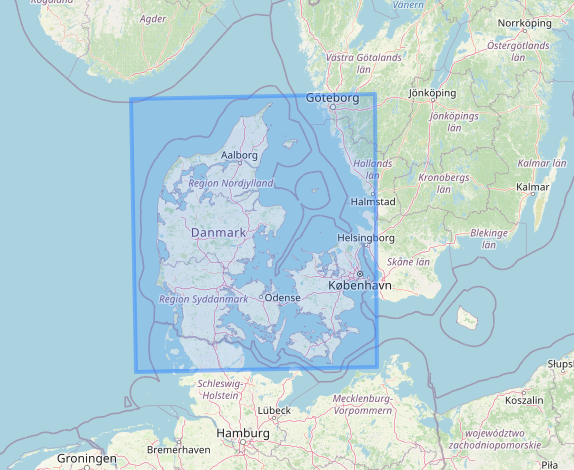

In [ ]:
# Get the list of all available stations
r = requests.get(DMI_URL_STATION, params={'api-key': api_key}, timeout=30)
json_data = r.json()

# Convert to DataFrame and clean column names in one step
stations = pd.json_normalize(json_data['features'])
stations.columns = [c.replace('properties.', '').replace('geometry.', '') for c in stations.columns]
 
# Filtering out stations not between certain latitude and longitude
# upper left: lat: 57.809651 long: 7.253075
# lower right: lat: 54.303704 long: 13.321548
stations = stations[(stations['coordinates'].apply(lambda x: x[1]) > 54.303704) &
                    (stations['coordinates'].apply(lambda x: x[1]) < 57.809651) &
                    (stations['coordinates'].apply(lambda x: x[0]) > 7.253075) &
                    (stations['coordinates'].apply(lambda x: x[0]) < 13.321548)]

# Filter for active stations with current locations in one step
stations = stations[(stations['status'] == 'Active') & (stations['validTo'].isna())]

# Filter for Danish stations
stations_DK = stations[stations['country'] == 'DNK']
stationIds_DK = stations_DK['stationId'].tolist()

# Extract unique parameters more efficiently
all_params = []
for feature in json_data['features']:
    param = feature['properties'].get('parameterId', [])
    if isinstance(param, list):
        all_params.extend(param)
    elif param:
        all_params.append(param)
        
parameterIds = sorted(list(set(all_params)))

# Print results
print(f"All parameters ({len(parameterIds)}): {parameterIds}")
print(f"Parameters in Danish stations ({len(parameterIds)}): {parameterIds}")
print(f"All station IDs ({len(stationIds_DK)}): {stationIds_DK}")
print(f"Total stations: {len(stations)}")
print(f"Danish stations: {len(stations_DK)}")
print(f"Greenlandic and Faroese stations: {len(stations) - len(stations_DK)}")

All parameters (47): ['cloud_cover', 'cloud_height', 'humidity', 'humidity_past1h', 'leav_hum_dur_past10min', 'leav_hum_dur_past1h', 'precip_dur_past10min', 'precip_dur_past1h', 'precip_past10min', 'precip_past1h', 'precip_past1min', 'precip_past24h', 'pressure', 'pressure_at_sea', 'radia_glob', 'radia_glob_past1h', 'snow_cover_man', 'snow_depth_man', 'sun_last10min_glob', 'sun_last1h_glob', 'temp_dew', 'temp_dry', 'temp_grass', 'temp_grass_max_past1h', 'temp_grass_mean_past1h', 'temp_grass_min_past1h', 'temp_max_past12h', 'temp_max_past1h', 'temp_mean_past1h', 'temp_min_past12h', 'temp_min_past1h', 'temp_soil', 'temp_soil_max_past1h', 'temp_soil_mean_past1h', 'temp_soil_min_past1h', 'visib_mean_last10min', 'visibility', 'weather', 'wind_dir', 'wind_dir_past1h', 'wind_gust_always_past1h', 'wind_max', 'wind_max_per10min_past1h', 'wind_min', 'wind_min_past1h', 'wind_speed', 'wind_speed_past1h']
All station IDs (213): ['31040', '20375', '05450', '05529', '06034', '21430', '06187', '06154'

In [ ]:
# stations[(stations['coordinates'].apply(lambda x: x[1]) > 54.303704) &
#                     (stations['coordinates'].apply(lambda x: x[1]) < 57.809651) &
#                     (stations['coordinates'].apply(lambda x: x[0]) > 7.253075) &
#                     (stations['coordinates'].apply(lambda x: x[0]) < 13.321548)]

# Test station IDs
# These are the station IDs for the test stations
test_stationIds = {
    "MEST N PUNKT DK, SKAGEN": '06041',
    "MEST V PUNKT DK, BLÅVANDSHUK": '06081',
    "MEST S PUNKT DK, GEDSER": '06149',
    "MEST Ø PUNKT DK, DROGDEN": '06183',
    "HAMMER, BORNHOLM": '06193',
    "BOREPLATFORM, GORM": '06023',
    "FÆRØERNE, Akraberg": '06009'
}

for name, stationId in test_stationIds.items():
    if stationId in stations['stationId'].values:
        station_row = stations[stations['stationId'] == stationId]
        coordinates = station_row.iloc[0]['coordinates']
        print(f"StationId {stationId} ({name}) YES in the dataset. Lat: {coordinates[1]}, Long: {coordinates[0]}")
    else:
        print(f"StationId {stationId} ({name}) not found.")

StationId 06041 (MEST N PUNKT DK, SKAGEN) YES in the dataset. Lat: 57.7364, Long: 10.6316
StationId 06081 (MEST V PUNKT DK, BLÅVANDSHUK) YES in the dataset. Lat: 55.5575, Long: 8.0828
StationId 06149 (MEST S PUNKT DK, GEDSER) YES in the dataset. Lat: 54.5687, Long: 11.9435
StationId 06183 (MEST Ø PUNKT DK, DROGDEN) YES in the dataset. Lat: 55.5364, Long: 12.7114
StationId 06193 (HAMMER, BORNHOLM) not found.
StationId 06023 (BOREPLATFORM, GORM) not found.
StationId 06009 (FÆRØERNE, Akraberg) not found.


In [12]:
parameterIds

['cloud_cover',
 'cloud_height',
 'humidity',
 'humidity_past1h',
 'leav_hum_dur_past10min',
 'leav_hum_dur_past1h',
 'precip_dur_past10min',
 'precip_dur_past1h',
 'precip_past10min',
 'precip_past1h',
 'precip_past1min',
 'precip_past24h',
 'pressure',
 'pressure_at_sea',
 'radia_glob',
 'radia_glob_past1h',
 'snow_cover_man',
 'snow_depth_man',
 'sun_last10min_glob',
 'sun_last1h_glob',
 'temp_dew',
 'temp_dry',
 'temp_grass',
 'temp_grass_max_past1h',
 'temp_grass_mean_past1h',
 'temp_grass_min_past1h',
 'temp_max_past12h',
 'temp_max_past1h',
 'temp_mean_past1h',
 'temp_min_past12h',
 'temp_min_past1h',
 'temp_soil',
 'temp_soil_max_past1h',
 'temp_soil_mean_past1h',
 'temp_soil_min_past1h',
 'visib_mean_last10min',
 'visibility',
 'weather',
 'wind_dir',
 'wind_dir_past1h',
 'wind_gust_always_past1h',
 'wind_max',
 'wind_max_per10min_past1h',
 'wind_min',
 'wind_min_past1h',
 'wind_speed',
 'wind_speed_past1h']

In [ ]:
def fetch_station_parameter_data(station, parameter, start_time, end_time, api_key):
    """Fetch data for a specific station and parameter combination."""
    datetime_str = start_time.tz_localize('UTC').isoformat() + '/' + end_time.tz_localize('UTC').isoformat()
    
    params = {
        'api-key': api_key,
        'datetime': datetime_str,
        'stationId': station,
        'parameterId': parameter,
        'limit': '300000',  # max limit
    }
    
    try:
        response = requests.get(DMI_URL_OBS, params=params, timeout=30)
        response.raise_for_status()
        
        json_data = response.json()
        df = pd.json_normalize(json_data.get('features', []))
        
        if df.empty:
            return None
        
        # Process the dataframe
        df['time'] = pd.to_datetime(df['properties.observed'])
        df = df[['time', 'properties.value', 'properties.stationId', 'properties.parameterId']]
        df.columns = [c.replace('properties.', '') for c in df.columns]
        df = df.drop_duplicates()
        
        return df
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for station {station}, parameter {parameter}: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error for station {station}, parameter {parameter}: {e}")
        return None

def fetch_all_data(stations, parameters, start_time, end_time, api_key):
    """Fetch data for all station and parameter combinations using parallel requests."""
    all_dfs = []
    combinations = [(station, parameter) for station in stations for parameter in parameters]
    total_combinations = len(combinations)
    
    print(f"Fetching data for {total_combinations} station-parameter combinations...")
    completed = 0
    
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Create a dictionary to track futures
        future_to_combo = {
            executor.submit(
                fetch_station_parameter_data, station, parameter, start_time, end_time, api_key
            ): (station, parameter) for station, parameter in combinations
        }
        
        # Process results as they complete
        for future in as_completed(future_to_combo):
            station, parameter = future_to_combo[future]
            completed += 1
            
            if completed % 5 == 0 or completed == total_combinations:
                print(f"Progress: {completed}/{total_combinations} combinations completed")
                
            try:
                df = future.result()
                if df is not None and not df.empty:
                    all_dfs.append(df)
                    print(f"Data found for station {station}, parameter {parameter}")
            except Exception as e:
                print(f"Error processing result for {station}-{parameter}: {e}")
            
            # Add small delay to avoid overwhelming the API
            if completed % 10 == 0 and completed > 0:
                time.sleep(1)
    
    # Combine all dataframes
    if not all_dfs:
        print("No data found for the given parameters and time range.")
        return pd.DataFrame()
    
    print(f"Processing {len(all_dfs)} dataframes with data...")
    
    # Combine all results
    combined_df = pd.concat(all_dfs, ignore_index=True)
    
    # Create multi-index pivot table
    pivot_df = combined_df.set_index(['parameterId', 'stationId', 'time'])['value']
    pivot_df = pivot_df.unstack(['stationId', 'parameterId']).sort_index()
    
    return pivot_df

# Example usage:
# Specific parameters to fetch (subset of all available)
parameters_to_fetch = ['weather']

# Specify the desired start and end time
start_time = pd.Timestamp(2022, 1, 1)
end_time = pd.Timestamp(2022, 1, 2)

# Call the function
result_df = fetch_all_data(stationIds_DK, parameters_to_fetch, start_time, end_time, api_key)
result_df.head()

Fetching data for 213 station-parameter combinations...
Progress: 5/213 combinations completed
Data found for station 06154, parameter weather
Progress: 10/213 combinations completed
Data found for station 06110, parameter weather
Progress: 15/213 combinations completed
Data found for station 06060, parameter weather
Data found for station 06096, parameter weather
Progress: 20/213 combinations completed
Data found for station 06018, parameter weather
Data found for station 06124, parameter weather
Progress: 25/213 combinations completed
Data found for station 06120, parameter weather
Progress: 30/213 combinations completed
Progress: 35/213 combinations completed
Data found for station 06058, parameter weather
Progress: 40/213 combinations completed
Progress: 45/213 combinations completed
Progress: 50/213 combinations completed
Progress: 55/213 combinations completed
Progress: 60/213 combinations completed
Data found for station 06183, parameter weather
Data found for station 06141, par

stationId,06154,06110,06060,06096,06018,06124,06120,06058,06183,06141,...,06180,06041,06159,06193,06074,06190,06030,06052,06023,06147
parameterId,weather,weather,weather,weather,weather,weather,weather,weather,weather,weather,...,weather,weather,weather,weather,weather,weather,weather,weather,weather,weather
time,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00+00:00,134.0,10.0,133.0,120.0,110.0,130.0,110.0,133.0,134.0,110.0,...,134.0,132.0,132.0,110.0,120.0,134.0,120.0,130.0,NaN,110.0
2022-01-01 00:10:00+00:00,133.0,NaN,133.0,120.0,110.0,120.0,110.0,132.0,134.0,110.0,...,130.0,132.0,132.0,110.0,120.0,133.0,130.0,133.0,NaN,110.0
2022-01-01 00:20:00+00:00,120.0,NaN,133.0,120.0,110.0,120.0,110.0,132.0,134.0,110.0,...,132.0,132.0,132.0,110.0,120.0,133.0,120.0,133.0,NaN,110.0
2022-01-01 00:30:00+00:00,120.0,NaN,133.0,120.0,110.0,120.0,110.0,120.0,134.0,110.0,...,120.0,132.0,134.0,110.0,120.0,130.0,133.0,133.0,NaN,110.0
2022-01-01 00:40:00+00:00,120.0,NaN,161.0,NaN,110.0,120.0,110.0,132.0,133.0,110.0,...,132.0,120.0,134.0,110.0,120.0,130.0,134.0,133.0,NaN,110.0


In [ ]:


# API Configuration
DMI_URL = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'
MAX_WORKERS = 5  # Limit concurrent requests to avoid API throttling

def fetch_parameter_data(station_id, parameter, chunk_start, chunk_end, api_key):
    """Fetch data for a specific parameter in a time chunk."""
    datetime_str = chunk_start.tz_localize('UTC').isoformat() + '/' + chunk_end.tz_localize('UTC').isoformat()
    
    params = {
        'api-key': api_key,
        'datetime': datetime_str,
        'stationId': station_id,
        'parameterId': parameter,
        'limit': '300000',  # max limit
    }
    
    try:
        response = requests.get(DMI_URL, params=params, timeout=30)
        response.raise_for_status()
        
        json_data = response.json()
        df = pd.json_normalize(json_data.get('features', []))
        
        if df.empty:
            print(f"No data found for parameter {parameter} in time period {chunk_start} to {chunk_end}")
            return None
        
        # Process the dataframe
        df['time'] = pd.to_datetime(df['properties.observed'])
        df = df[['time', 'properties.value', 'properties.parameterId']]
        df.columns = [c.replace('properties.', '') for c in df.columns]
        df = df.drop_duplicates()
        
        print(f"Retrieved {len(df)} records for parameter {parameter} from {chunk_start} to {chunk_end}")
        return df
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for parameter {parameter}: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error for parameter {parameter}: {e}")
        return None

def fetch_station_data(station_id, parameters, start_time, end_time, api_key, chunk_size_days=30):
    """Fetch multiple parameters for a single station with time chunking."""
    all_dfs = []
    
    # Break the time range into chunks
    current_start = start_time
    chunk_num = 1
    
    while current_start < end_time:
        # Calculate chunk end (or use end_time if it's closer)
        current_end = min(current_start + pd.Timedelta(days=chunk_size_days), end_time)
        
        print(f"\nProcessing chunk {chunk_num}: {current_start} to {current_end}")
        
        # Fetch all parameters for this time chunk in parallel
        chunk_dfs = []
        with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
            # Create futures for each parameter in this time chunk
            futures = {
                executor.submit(fetch_parameter_data, station_id, param, current_start, current_end, api_key): param
                for param in parameters
            }
            
            # Process results as they complete
            for future in as_completed(futures):
                param = futures[future]
                try:
                    df = future.result()
                    if df is not None and not df.empty:
                        chunk_dfs.append(df)
                except Exception as e:
                    print(f"Error processing result for parameter {param}: {e}")
        
        # Combine all parameter dataframes for this time chunk
        if chunk_dfs:
            chunk_combined = pd.concat(chunk_dfs, ignore_index=True)
            all_dfs.append(chunk_combined)
            print(f"Completed chunk {chunk_num} with {len(chunk_dfs)} parameters")
        
        # Move to next chunk
        current_start = current_end
        chunk_num += 1
        
        # Add a small delay between chunks to avoid overwhelming the API
        time.sleep(2)
    
    # Combine all chunks
    if not all_dfs:
        print("No data found for the given parameters and time range.")
        return pd.DataFrame()
    
    # Combine all results
    combined_df = pd.concat(all_dfs, ignore_index=True)
    
    # Create pivot table with time as index and parameters as columns
    pivot_df = combined_df.pivot_table(
        index='time', 
        columns='parameterId',
        values='value'
    )
    
    return pivot_df

# Example usage:
# station_id = '06041'  # Copenhagen/Kastrup
# parameters_to_fetch = ['temp_dry', 'humidity', 'wind_dir', 'wind_speed', 'pressure']
# start_time = pd.Timestamp(2022, 1, 1)
# end_time = pd.Timestamp(2022, 12, 31)
# result_df = fetch_station_data(station_id, parameters_to_fetch, start_time, end_time, api_key)

# Claude goin' crazy

In [ ]:
import requests
import json
import pandas as pd
import datetime
import concurrent.futures
from typing import Dict, List, Optional, Union, Tuple
import backoff  # New import for retries
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Base URL for DMI Meteorological Observation API
BASE_URL = "https://dmigw.govcloud.dk/v2/metObs/collections/observation/items"

# Add retry mechanism to handle transient failures
@backoff.on_exception(backoff.expo, 
                     (requests.exceptions.RequestException,),
                     max_tries=5,
                     jitter=None)
def fetch_single_request(api_key: str, 
                        stationId: str, 
                        parameterIds: str, 
                        datetime_str: str,
                        limit: int = 300000) -> Tuple[str, str, pd.DataFrame]:
    """
    Fetch data for a single station-parameter combination with retry logic.
    """
    headers = {"X-API-Key": api_key}
    params = {
        'datetime': datetime_str,
        'stationIds': stationId,
        'parameterId': parameterIds,
        'limit': str(limit),
    }
    
    try:
        response = requests.get(BASE_URL, headers=headers, params=params, timeout=30)
        response.raise_for_status()  # Raise exception for bad status codes
        
        json_data = response.json()
        features = json_data.get('features', [])
        
        if not features:
            logger.info(f"No data for station {stationId}, parameter {parameterIds}")
            return stationId, parameterIds, pd.DataFrame()
            
        # Use list comprehension instead of json_normalize for better performance
        data = []
        for feature in features:
            props = feature['properties']
            data.append({
                'time': props['observed'],
                'value': props['value'],
                'stationIds': props['stationIds'],
                'parameterId': props['parameterId']
            })
            
        df = pd.DataFrame(data)
        # Convert time once after creation rather than during load
        df['time'] = pd.to_datetime(df['time'])
        df = df[~df.duplicated()]
        return stationId, parameterIds, df
        
    except Exception as e:
        logger.error(f"Error for station {stationId}, parameter {parameterIds}: {str(e)}")
        # Let backoff handle the retry if needed
        raise

def get_all_data_concurrent(api_key: str,
                           stationIds: List[str],
                           parameterIds: List[str],
                           startTime: pd.Timestamp,
                           endTime: pd.Timestamp,
                           chunk_size: pd.Timedelta = pd.Timedelta(days=30),  # Break into smaller time chunks
                           max_workers: int = 10,
                           limit: int = 300000) -> pd.DataFrame:
    """
    Fetch meteorological data for multiple stations and parameters concurrently.
    Optimized with time chunking for very large date ranges.
    """
    # Generate time chunks to avoid hitting API limits
    time_chunks = []
    current_start = startTime
    while current_start < endTime:
        current_end = min(current_start + chunk_size, endTime)
        time_chunks.append((current_start, current_end))
        current_start = current_end
        
    all_dfs = []
    total_tasks = len(stationIds) * len(parameterIds) * len(time_chunks)
    completed = 0
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for start_chunk, end_chunk in time_chunks:
            datetime_str = start_chunk.tz_localize('UTC').isoformat() + '/' + end_chunk.tz_localize('UTC').isoformat()
            for station in stationIds:
                for parameter in parameterIds:
                    futures.append(
                        executor.submit(
                            fetch_single_request, 
                            api_key, 
                            station, 
                            parameter, 
                            datetime_str, 
                            limit
                        )
                    )
        
        # Process results as they complete
        for future in concurrent.futures.as_completed(futures):
            completed += 1
            try:
                stationId, parameterId, df = future.result()
                if not df.empty:
                    logger.info(f"Completed {completed}/{total_tasks}: Station {stationId}, Parameter {parameterId}")
                    all_dfs.append(df)
                else:
                    logger.info(f"No data for {completed}/{total_tasks}: Station {stationId}, Parameter {parameterId}")
            except Exception as e:
                logger.error(f"Error processing task {completed}/{total_tasks}: {str(e)}")
    
    if not all_dfs:
        return pd.DataFrame()
        
    # More efficient concatenation with copy=False
    combined_df = pd.concat(all_dfs, ignore_index=True, copy=False)
    combined_df['value'] = pd.to_numeric(combined_df['value'], errors='coerce')
    
    # Use a more memory-efficient pivot operation
    # First groupby to reduce data size before pivoting
    grouped = combined_df.groupby(['time', 'parameterId', 'stationIds'])['value'].mean().reset_index()
    pivoted_df = grouped.pivot_table(
        index='time', 
        columns=['parameterId', 'stationIds'], 
        values='value'
    )
    
    return pivoted_df

def fetch_all_stations(api_key: str) -> List[Dict]:
    """
    Fetch all station information with pagination support.
    Returns detailed station information instead of just IDs.
    """
    url = "https://dmigw.govcloud.dk/v2/metObs/collections/station/items"
    headers = {"X-API-Key": api_key}
    
    all_features = []
    page = 1
    limit = 100  # Smaller batch size for each request
    
    while True:
        params = {"limit": str(limit), "page": str(page)}
        response = requests.get(url, headers=headers, params=params, timeout=30)
        
        if response.status_code == 200:
            data = response.json()
            features = data.get('features', [])
            
            if not features:
                break
                
            all_features.extend(features)
            page += 1
            
            # Check if we got fewer items than the limit (last page)
            if len(features) < limit:
                break
        else:
            raise Exception(f"Error fetching stations: {response.status_code} - {response.text}")
    
    # Return the full station details for further filtering
    return all_features

def fetch_all_parameters(api_key: str) -> List[Dict]:
    """
    Fetch all parameter information with pagination support.
    Returns detailed parameter information instead of just IDs.
    """
    url = "https://dmigw.govcloud.dk/v2/metObs/collections/parameter/items"
    headers = {"X-API-Key": api_key}
    
    all_features = []
    page = 1
    limit = 100  # Smaller batch size for each request
    
    while True:
        params = {"limit": str(limit), "page": str(page)}
        response = requests.get(url, headers=headers, params=params, timeout=30)
        
        if response.status_code == 200:
            data = response.json()
            features = data.get('features', [])
            
            if not features:
                break
                
            all_features.extend(features)
            page += 1
            
            # Check if we got fewer items than the limit (last page)
            if len(features) < limit:
                break
        else:
            raise Exception(f"Error fetching parameters: {response.status_code} - {response.text}")
    
    # Return the full parameter details for further filtering
    return all_features

def filter_active_stations(api_key: str, days_threshold: int = 7) -> List[str]:
    """
    Filter active stations more efficiently by making batch requests
    instead of one request per station.
    """
    all_stations = fetch_all_stations(api_key)
    station_ids = [feature['properties']['stationIds'] for feature in all_stations]
    
    now = pd.Timestamp.now(tz='UTC')
    threshold = now - pd.Timedelta(days=days_threshold)
    threshold_str = threshold.isoformat()
    
    # Process stations in batches to reduce API calls
    batch_size = 5  # Process 5 stations per request
    active_stations = []
    headers = {"X-API-Key": api_key}
    
    for i in range(0, len(station_ids), batch_size):
        batch = station_ids[i:i+batch_size]
        station_param = ','.join(batch)
        
        params = {
            'stationIds': station_param,
            'datetime': threshold_str + '/' + now.isoformat(),
            'limit': str(len(batch) * 10)  # Allow for multiple records per station
        }
        
        try:
            response = requests.get(BASE_URL, headers=headers, params=params, timeout=30)
            if response.status_code == 200:
                data = response.json()
                features = data.get('features', [])
                
                # Extract unique station IDs from the response
                found_stations = set()
                for feature in features:
                    found_stations.add(feature['properties']['stationIds'])
                
                # Add active stations to our list
                for station in found_stations:
                    active_stations.append(station)
                    logger.info(f"Station {station} is active")
            else:
                logger.error(f"Error checking stations {batch}: {response.status_code}")
                
        except Exception as e:
            logger.error(f"Error checking stations {batch}: {str(e)}")
    
    return active_stations

# Cache decorator to avoid repeated identical API calls
def memoize(func):
    cache = {}
    def wrapper(*args, **kwargs):
        key = str(args) + str(kwargs)
        if key not in cache:
            cache[key] = func(*args, **kwargs)
        return cache[key]
    return wrapper

# Apply caching to frequently called functions
fetch_all_stations = memoize(fetch_all_stations)
fetch_all_parameters = memoize(fetch_all_parameters)

# Example usage
if __name__ == "__main__":
    api_key = "d111ba1d-a1f5-43a5-98c6-347e9c2729b2"  # Don't hardcode API keys
    startTime = pd.Timestamp(2022, 1, 1)
    endTime = pd.Timestamp(2022, 1, 2)

    stationIds = ['04203']  # Keep short for testing
    parameterIds = ['temp_dew']

    logger.info(f"Fetching data for {len(stationIds)} stations and {len(parameterIds)} parameters...")
    weather_data = get_all_data_concurrent(
        api_key=api_key,
        stationIds=stationIds,
        parameterIds=parameterIds,
        startTime=startTime,
        endTime=endTime,
        max_workers=5
    )

    logger.info(f"Retrieved data shape: {weather_data.shape}")
    logger.info(weather_data.head())

    if not weather_data.empty:
        weather_data.to_csv("dmi_weather_data_concurrent.csv")
        logger.info("Data saved to dmi_weather_data_concurrent.csv")
    else:
        logger.warning("No data retrieved.")